# Outlier Method of Filtering

**Mostafa Kamal Mostafa Kamel (mos.kamal@nu.edu.eg)**


## Eval


In [1]:
from seasalt.seasalt import *
from glob import glob
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from rich.progress import Progress

from scipy.signal import medfilt
import warnings
import seaborn as sns
from seasalt.cython_seasalt import fixed_window_outlier_filter

warnings.filterwarnings("ignore")
path_to_images = Path().resolve().joinpath("BSDS300-test")
image_paths = glob(f"{str(path_to_images)}/*.jpg")


def plot_transformation_hist_eq(
    im, sp_ratio, size=3, max_size=15, save_path: Optional[str] = None
) -> tuple[float, float, float, float, float]:
    im_gs = im.convert("L")
    arr = np.array(im_gs)  # convert the PIL image object to array
    seasoned_image = apply_salt_pepper(arr, ratio=sp_ratio)
    median_filter_corrected_image = medfilt(np.copy(seasoned_image), size)
    akernel_mean = adaptive_kernel_size(
        np.copy(seasoned_image),
        max_size=max_size,
        correction_function=weighted_mean,
    )
    akernel_median = adaptive_kernel_size(
        np.copy(seasoned_image),
        max_size=max_size,
        correction_function=weighted_median,
    )
    corrected_novel = fixed_window_outlier_filter(np.copy(seasoned_image), size)
    noise_baseline_snr = signal_to_noise_ratio(im_gs, np.copy(seasoned_image))
    med_snr = signal_to_noise_ratio(im_gs, median_filter_corrected_image)
    akernel_mean_snr = signal_to_noise_ratio(im_gs, akernel_mean)
    akernel_median_snr = signal_to_noise_ratio(im_gs, akernel_median)
    novel_snr = signal_to_noise_ratio(im_gs, corrected_novel)
    fig = plt.figure(
        figsize=(
            im_gs.size[0] * 1 / 24,
            im_gs.size[1] * 1 / 15,
        ),
        dpi=80,
    )
    gs = fig.add_gridspec(3, 2, hspace=0.12, wspace=0.08)
    axes = gs.subplots(sharex="col", sharey="row")
    list(map(lambda ax: ax.set_axis_off(), axes.flatten()))
    list(  # type: ignore
        map(
            lambda input: input[0].set_title(input[1]),
            zip(
                axes.flatten(),
                [
                    "Original",
                    f"Noisy Image {round(noise_baseline_snr, 2)} dB",
                    f"Median Filter {round(med_snr, 2)} dB",
                    "Adaptive Kernel - WMean\n" f"{round(akernel_mean_snr, 2)} dB",
                    "Adaptive Kernel - WMedian\n" f"{round(akernel_median_snr, 2)} dB",
                    "Novel Approach\n" f"{round(novel_snr, 2)} dB",
                ],
            ),
        )
    )
    axes[0][0].imshow(im_gs, cmap="gray", vmin=0, vmax=255)
    axes[0][1].imshow(seasoned_image, cmap="gray", vmin=0, vmax=255)
    axes[1][0].imshow(median_filter_corrected_image, cmap="gray", vmin=0, vmax=255)
    axes[1][1].imshow(akernel_mean, cmap="gray", vmin=0, vmax=255)
    axes[2][0].imshow(akernel_median, cmap="gray", vmin=0, vmax=255)
    axes[2][1].imshow(corrected_novel, cmap="gray", vmin=0, vmax=255)
    if save_path:
        plt.axis("off")
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path)
        plt.close()
    return (
        noise_baseline_snr,
        med_snr,
        akernel_mean_snr,
        akernel_median_snr,
        novel_snr,
    )

In [2]:
def plot_single_image(seasoned_arr):
    fig = plt.figure(
        figsize=(
            10,
            20,
        ),
        dpi=80,
    )
    gs = fig.add_gridspec(1, 1, hspace=0.12, wspace=0.08)
    ax = gs.subplots(sharex="col", sharey="row")
    ax.imshow(seasoned_arr, cmap="gray", vmin=0, vmax=255)
    ax.set_axis_off()

In [3]:
data_dict_eq = dict(
    im_index=[],
    sp=[],
    noise_baseline_snr=[],
    med_snr=[],
    akernel_mean_snr=[],
    akernel_median_snr=[],
    novel_snr=[],
)
root_path = Path().resolve().joinpath("aof_eval").joinpath("eq")

with Progress() as progress:
    task = progress.add_task("Running...", total=len(image_paths) * 9)

    for p in image_paths:
        img_name = p.split("/")[-1].split(".")[0]
        for sp, size in zip(
            [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
            [3, 3, 5, 7, 15, 15, 15, 15, 31],
        ):
            im = Image.open(p)
            (
                noise_baseline_snr,
                med_snr,
                akernel_mean_snr,
                akernel_median_snr,
                novel_snr,
            ) = plot_transformation_hist_eq(
                im,
                sp_ratio=sp,
                size=size,
                save_path=f"./images/{p.split('/')[-1].split('.')[0]}/{int(sp*100)}.png",
            )
            data_dict_eq["im_index"].append(img_name)
            data_dict_eq["sp"].append(sp)
            data_dict_eq["noise_baseline_snr"].append(noise_baseline_snr)
            data_dict_eq["med_snr"].append(med_snr)
            data_dict_eq["akernel_mean_snr"].append(akernel_mean_snr)
            data_dict_eq["akernel_median_snr"].append(akernel_median_snr)
            data_dict_eq["novel_snr"].append(novel_snr)
            progress.update(task, advance=1)

Output()

In [10]:
sns.set_theme()

In [4]:
df_eq = pd.DataFrame(data_dict_eq)
df_eq.to_pickle("df_eq.pkl")

In [5]:
df_aof_agg = df_eq.groupby("sp").agg(
    {
        "noise_baseline_snr": [np.mean],
        "med_snr": [np.mean],
        "akernel_mean_snr": [np.mean],
        "akernel_median_snr": [np.mean],
        "novel_snr": [np.mean],
    }
)

In [6]:
df_aof_agg = df_aof_agg.reset_index()
df_aof_agg.columns = [
    "sp",
    "mean_noise_baseline_snr",
    "mean_med_snr",
    "mean_akernel_mean_snr",
    "mean_akernel_median_snr",
    "mean_novel_snr",
]

In [7]:
df_aof_agg

,sp,mean_noise_baseline_snr,mean_med_snr,mean_akernel_mean_snr,mean_akernel_median_snr,mean_novel_snr
0,0.20,12.078905,25.332390,28.053218,28.333427,31.594093
1,0.30,10.315968,21.674038,26.250995,26.556864,29.945197
2,0.40,9.067461,22.576644,25.015460,25.309588,29.053401
3,0.50,8.097568,21.210042,24.030079,24.302820,27.984295
4,0.60,7.306439,18.502624,23.221363,23.467726,26.724997
5,0.70,6.636080,17.903077,22.525206,22.730266,25.974029
6,0.80,6.055844,16.914729,21.870026,22.000718,24.965976
7,0.90,5.545845,11.959227,21.153510,21.127725,23.170809
8,0.95,5.310545,11.140848,20.482722,20.236035,21.908089


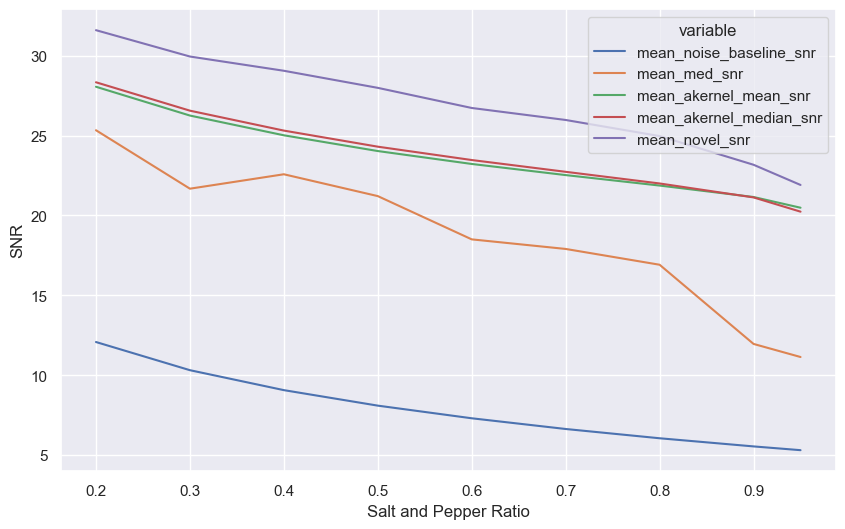

In [11]:
df_melted = df_aof_agg.melt(id_vars="sp", var_name="variable", value_name="value")


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x="sp", y="value", hue="variable")

plt.xlabel("Salt and Pepper Ratio")
plt.ylabel("SNR")
plt.show()

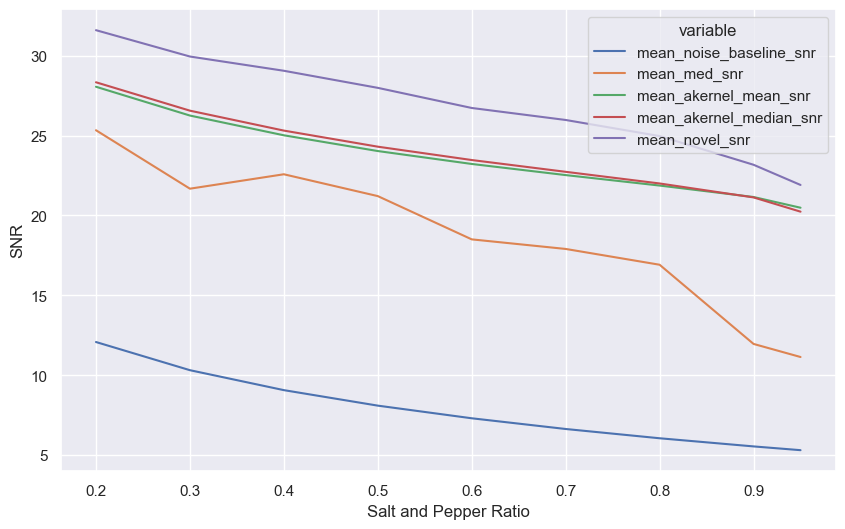

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_melted[
        df_melted.variable.isin(
            [
                "mean_noise_baseline_snr",
                "mean_med_snr",
                "mean_akernel_mean_snr",
                "mean_akernel_median_snr",
                "mean_novel_snr",
            ]
        )
    ],
    x="sp",
    y="value",
    hue="variable",
)

plt.xlabel("Salt and Pepper Ratio")
plt.ylabel("SNR")
plt.show()